In [1]:
import fasttext
import nltk
import csv
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
def load_FinnSentiment_data():
    """
    Load sentences and labels from FinnSentiment data set.
    """
    df = pd.read_csv('FinnSentiment2020.tsv', sep='\t', header=None, quoting=csv.QUOTE_NONE)
    df = df.rename(columns={10: "sentence", 3: "label"})

    #change labels to negative = 0, neutral = 1, positive = 2
    df['label'] += 1

    sentences = df['sentence'].tolist()
    labels = df['label'].tolist()

    print('number of sentences:', len(sentences))
    print('number of labels:', len(labels))
    return sentences, labels

In [3]:
def get_word_vectors(texts, max_words_in_text):
    """
    Transform iterable of texts into word vectors using FastText
    Texts that are longer than max_word_in_text are truncated
    """
    num_texts = len(texts)
    word_vector_len = 300

    #init array that contains all word embedding matrices
    word_vectors = np.zeros((num_texts, max_words_in_text, word_vector_len))

    fasttext_model = fasttext.load_model("cc.fi.300.bin")
    for i in range(num_texts):
        words = nltk.word_tokenize(texts[i])
        for j in range(min(max_words_in_text, len(words))):
            word_vector = fasttext_model.get_word_vector(words[j])
            word_vectors[i][j] = word_vector
    return word_vectors

In [4]:
def plot_classification_results(y_test, y_pred):
    """
    Plot test set results
    The values in the arrays are 0=negative, 1=neutral and 2=positive
    """
    ax = sns.countplot(x=y_test, hue=y_pred);
    ax.set_xticklabels(['negative', 'neutral', 'positive'])
    ax.set_xlabel('actual class', fontweight='bold')
    ax.legend(['negative', 'neutral', 'positive'], title='predicted class')

In [5]:
sentences, labels = load_FinnSentiment_data()

#lowercase sentences
sentences = [sentence.lower() for sentence in sentences]

#split data to training set and test set
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.20, 
                                                                              shuffle=True, random_state=1)

#split training set to training set and validation set
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels,
                                                                            test_size=1/8, shuffle=False)

print("number of training samples:", len(train_sentences))
print("number of validation samples:", len(val_sentences))
print("number of test samples:", len(test_sentences))

number of sentences: 27000
number of labels: 27000
number of training samples: 18900
number of validation samples: 2700
number of test samples: 5400


In [6]:
#make word embeddings
X_train = get_word_vectors(train_sentences, max_words_in_text=29)
X_val = get_word_vectors(val_sentences, max_words_in_text=29)
X_test = get_word_vectors(test_sentences, max_words_in_text=29)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [7]:
CNN_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(29,300)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=4, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])

CNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy')
CNN_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping])

Epoch 1/10
1182/1182 [==============================] - 19s 15ms/step - loss: 0.7008 - accuracy: 0.7486 - val_loss: 0.5598 - val_accuracy: 0.7807
Epoch 2/10
1182/1182 [==============================] - 13s 11ms/step - loss: 0.5201 - accuracy: 0.7926 - val_loss: 0.5107 - val_accuracy: 0.7944
Epoch 3/10
1182/1182 [==============================] - 14s 12ms/step - loss: 0.4495 - accuracy: 0.8227 - val_loss: 0.4943 - val_accuracy: 0.8048
Epoch 4/10
1182/1182 [==============================] - 13s 11ms/step - loss: 0.3922 - accuracy: 0.8438 - val_loss: 0.5156 - val_accuracy: 0.7974


              precision    recall  f1-score   support

           0       0.50      0.44      0.47       819
           1       0.85      0.91      0.88      3963
           2       0.82      0.59      0.68       618

    accuracy                           0.80      5400
   macro avg       0.72      0.64      0.68      5400
weighted avg       0.79      0.80      0.79      5400



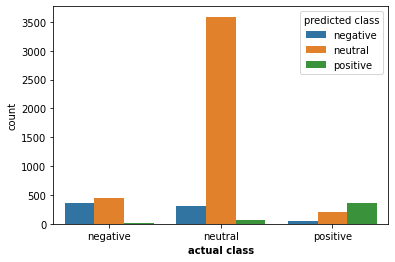

In [8]:
#make test set predictions
y_pred = CNN_model.predict(X_test)

#choose the class with the highest probability to be the prediction
y_pred = tf.math.argmax(y_pred, axis=1)
y_pred = np.array(y_pred)

print(classification_report(y_test, y_pred))
plot_classification_results(y_test, y_pred)

In [9]:
#save predictions for later examination
np.save('CNN-test-predictions', y_pred)

In [10]:
LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=0.0, input_shape=(29,300)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(3, activation='softmax')
])

LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy')
LSTM_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping])

Epoch 1/10
1182/1182 [==============================] - 28s 18ms/step - loss: 0.6755 - accuracy: 0.7587 - val_loss: 0.5367 - val_accuracy: 0.7841
Epoch 2/10
1182/1182 [==============================] - 19s 16ms/step - loss: 0.4998 - accuracy: 0.8100 - val_loss: 0.4939 - val_accuracy: 0.8078
Epoch 3/10
1182/1182 [==============================] - 19s 16ms/step - loss: 0.4699 - accuracy: 0.8116 - val_loss: 0.4705 - val_accuracy: 0.8170
Epoch 4/10
1182/1182 [==============================] - 19s 16ms/step - loss: 0.4489 - accuracy: 0.8250 - val_loss: 0.4862 - val_accuracy: 0.8137


              precision    recall  f1-score   support

           0       0.68      0.23      0.35       819
           1       0.83      0.95      0.89      3963
           2       0.73      0.71      0.72       618

    accuracy                           0.81      5400
   macro avg       0.75      0.63      0.65      5400
weighted avg       0.80      0.81      0.79      5400



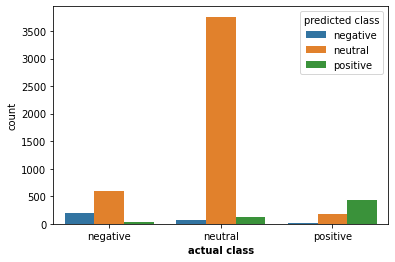

In [11]:
#make test set predictions
y_pred = LSTM_model.predict(X_test)

#choose the class with the highest probability to be the prediction
y_pred = tf.math.argmax(y_pred, axis=1)
y_pred = np.array(y_pred)

print(classification_report(y_test, y_pred))
plot_classification_results(y_test, y_pred)

In [12]:
#save predictions for later examination
np.save('LSTM-test-predictions', y_pred)

In [13]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=0.0, input_shape=(29,300)),
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(3)
])

GRU_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy')
GRU_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[early_stopping])

Epoch 1/10
1182/1182 [==============================] - 24s 16ms/step - loss: 0.6657 - accuracy: 0.7599 - val_loss: 0.5271 - val_accuracy: 0.7922
Epoch 2/10
1182/1182 [==============================] - 17s 15ms/step - loss: 0.4931 - accuracy: 0.8115 - val_loss: 0.4804 - val_accuracy: 0.8178
Epoch 3/10
1182/1182 [==============================] - 17s 15ms/step - loss: 0.4598 - accuracy: 0.8181 - val_loss: 0.4634 - val_accuracy: 0.8156


              precision    recall  f1-score   support

           0       0.62      0.41      0.49       819
           1       0.85      0.93      0.89      3963
           2       0.81      0.64      0.72       618

    accuracy                           0.82      5400
   macro avg       0.76      0.66      0.70      5400
weighted avg       0.81      0.82      0.81      5400



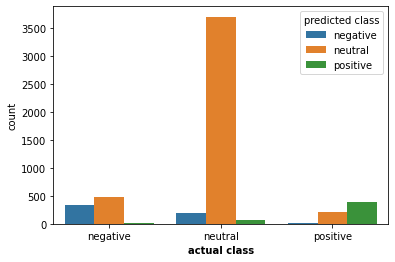

In [14]:
#make test set predictions
y_pred = GRU_model.predict(X_test)

#choose the class with the highest probability to be the prediction
y_pred = tf.math.argmax(y_pred, axis=1)
y_pred = np.array(y_pred)

print(classification_report(y_test, y_pred))
plot_classification_results(y_test, y_pred)

In [15]:
#save predictions for later examination
np.save('GRU-test-predictions', y_pred)